In [41]:
!pip install tensorflow tensorflow-datasets matplotlib ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.6 MB/s eta 0:00:00


In [42]:
%cd '/'

/


In [43]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

In [44]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [45]:
df, df_info = tfds.load('cifar10', split='train', with_info=True)

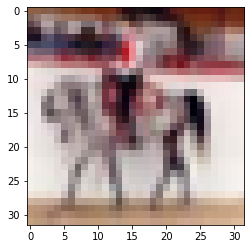

In [46]:
dataiter = df.as_numpy_iterator()
plt.imshow(np.squeeze(dataiter.next()['image']))

In [47]:
dataiter.next()['image'].shape

(32, 32, 3)

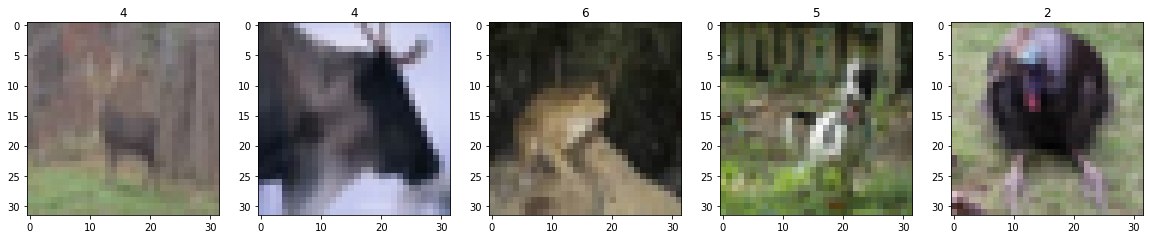

In [48]:
fix, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx in range(5):
  batch = dataiter.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

In [49]:
def scaleimg(data):
  img = data['image']
  return img/255

In [50]:
df = df.map(scaleimg)
df = df.cache()
df = df.shuffle(60000)
df = df.batch(128)
df = df.prefetch(64)

In [51]:
df.as_numpy_iterator().next().shape

(128, 32, 32, 3)

**Building Generator**

In [52]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Reshape, Conv2D, UpSampling2D, Dropout, Flatten

In [53]:
def build_generator():
  with tf.device(device_name):
    model = Sequential()
    model.add(Dense(8*8*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8,8,128)))

    #upsampling block-1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #upsampling block-2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    #Conv layer-1
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    #Conv layer-2
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    #Conv layer-3
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))
    return model

In [54]:
generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              1056768   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                      

In [55]:
#generating 4 random images of 128 size
img = generator.predict(np.random.randn(4,128))
img.shape

1/1 [==============================] - 0s 101ms/step


(4, 32, 32, 3)

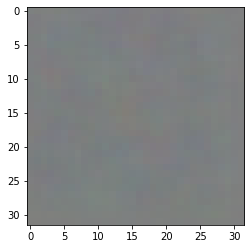

In [56]:
plt.imshow(img[0])

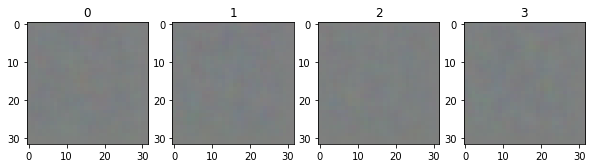

In [57]:
fix, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, i in enumerate(img):
  ax[idx].imshow(i)
  ax[idx].title.set_text(idx)

In [58]:
def build_discriminator():
  with tf.device(device_name):
    
    model=Sequential()

    #first conv layer
    model.add(Conv2D(32, 5, input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #second conv layer
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #third conv layer
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #fourth conv layer
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #layer to output T/F
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [59]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 64)        51264     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 24, 24, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 20, 128)      

In [60]:
#passing a batch of images
discriminator.predict(img)

1/1 [==============================] - 0s 82ms/step


array([[0.48121074],
       [0.48101947],
       [0.4814415 ],
       [0.48132262]], dtype=float32)

In [61]:
#passing a single image do this as model expects batch number as first dimention
discriminator.predict(np.expand_dims(img[0], 0))

1/1 [==============================] - 0s 21ms/step


array([[0.48121062]], dtype=float32)

Setting-up losses and optimizers

In [62]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [63]:

g_opt = Adam(learning_rate=0.002)
d_opt = Adam(learning_rate=0.0004)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [64]:
#Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [65]:
df.as_numpy_iterator().next().shape

(128, 32, 32, 3)

### Class for creating our GAN

In [66]:
class GAN(Model):
  with tf.device(device_name):
    #*args - arguments, **kwargs - key-word arguments
    def __init__(self, generator, discriminator, *args, **kwargs):
      #Pass through args and kwargs to base class
      super().__init__(*args, **kwargs)

      #Creating attributes for generator and discriminator
      self.gen = generator
      self.disc = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
      #Compile with base-class
      super().compile(*args, **kwargs)

      #Attribs for optimizers and losses
      self.g_opt = g_opt
      self.d_opt = d_opt
      self.g_loss = g_loss
      self.d_loss = d_loss

    def train_step(self, batch):
      real = batch
      fake = self.gen(tf.random.normal((128, 128, 1)), training=False)

      #Train the discriminator
      with tf.GradientTape() as d_tape:
        #1. Pass real and fake images to discriminator
        yhat_real = self.disc(real, training=True)
        yhat_fake = self.disc(fake, training=True)
        yhat = tf.concat([yhat_real, yhat_fake], axis=0)

        #2. Create labels for real and fake images
        y = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0) #yhat_real values are now 0s and yhat_fake are 1s

        #3. Add noise to the output of discriminator to slow it down
        noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
        noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
        y += tf.concat([noise_real, noise_fake], axis=0)
        
        #4. Calculate the loss
        total_d_loss = self.d_loss(y, yhat)

      #Backprop to update weights
      d_grad = d_tape.gradient(total_d_loss, self.disc.trainable_variables)
      self.d_opt.apply_gradients(zip(d_grad, self.disc.trainable_variables))

      #train the generator
      with tf.GradientTape() as g_tape:
        #1. Generate some new images
        gen_images = self.gen(tf.random.normal((128, 128, 1)), training = True)

        #2. Create predicted labels
        predicted_labels = self.disc(gen_images, training=False)

        #3. Calculate loss
        total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
          
      #Apply backprop
      g_grad = g_tape.gradient(total_g_loss, self.gen.trainable_variables)
      self.g_opt.apply_gradients(zip(g_grad, self.gen.trainable_variables))

      return {"d_loss ":total_d_loss, "g_loss ":total_g_loss}

In [67]:
gan = GAN(generator, discriminator)

In [68]:
gan.compile(g_opt, d_opt, g_loss, d_loss)

### Build callback function

In [69]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [70]:
class ModelMonitor(Callback):
  with tf.device(device_name):
    def __init__(self, num_img=3, latent_dim=128):
      self.num_img=num_img
      self.latent_dim=latent_dim
    
    def on_epoch_end(self, epochs, logs=None):
      random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
      generated_images = self.model.gen(random_latent_vectors)
      generated_images *=255
      generated_images.numpy()

      for i in range(self.num_img):
        img = array_to_img(generated_images[i])
        img.save(os.path.join('/GAN-Images', f'generated_image_{epochs}_{i}.png'))

### Training the model

In [71]:
PATH = '/content/drive/MyDrive/Colab\ Notebooks'

In [72]:
%ls

bin@      etc/         lib64@                    opt/         sbin@   usr/
boot/     GAN-Images/  libx32@                   proc/        srv/    var/
content/  home/        media/                    python-apt/  sys/
datalab/  lib@         mnt/                      root/        tmp/
dev/      lib32@       NGC-DL-CONTAINER-LICENSE  run/         tools/


In [73]:
hist = gan.fit(df, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/391 [..............................] - ETA: 2:06 - d_loss : 0.7011 - g_loss : 0.8811

391/391 [==============================] - 127s 313ms/step - d_loss : 0.3227 - g_loss : 3.0761
Epoch 2/20
391/391 [==============================] - 121s 309ms/step - d_loss : 0.2675 - g_loss : 2.8751
Epoch 3/20
391/391 [==============================] - 121s 309ms/step - d_loss : 0.2677 - g_loss : 2.7666
Epoch 4/20
391/391 [==============================] - 121s 310ms/step - d_loss : 0.2676 - g_loss : 2.7996
Epoch 5/20
391/391 [==============================] - 121s 310ms/step - d_loss : 0.2680 - g_loss : 2.8134
Epoch 6/20
391/391 [==============================] - 121s 309ms/step - d_loss : 0.2685 - g_loss : 2.7537
Epoch 7/20
391/391 [==============================] - 119s 303ms/step - d_loss : 6.9723 - g_loss : 0.3157
Epoch 8/20
391/391 [==============================] - 118s 302ms/step - d_loss : 7.7179 - g_loss : 0.0000e+00
Epoch 9/20
391/391 [==============================] - 118s 302ms/step - d_loss : 7.7211 - g_loss : 0.0000e+00
Epoch 10/20
391/391 [============================

### Review Performance

In [74]:
hist.history

{'d_loss ': [0.2662633955478668,
  0.2701270282268524,
  0.27538570761680603,
  0.2656201720237732,
  0.2740985155105591,
  0.25500577688217163,
  9.217329025268555,
  9.227861404418945,
  9.174949645996094,
  9.120838165283203,
  9.188724517822266,
  9.215883255004883,
  9.181270599365234,
  9.20213508605957,
  9.288748741149902,
  9.173385620117188,
  9.20633316040039,
  9.20470905303955,
  9.194400787353516,
  9.24702262878418],
 'g_loss ': [2.981294631958008,
  2.7743990421295166,
  2.5679426193237305,
  2.9741804599761963,
  2.7727808952331543,
  3.00669002532959,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]}

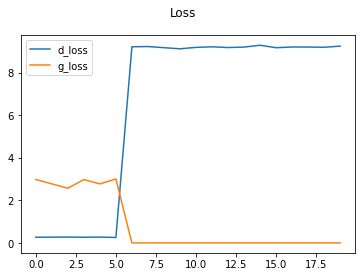

In [76]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss '], label='d_loss')
plt.plot(hist.history['g_loss '], label='g_loss')
plt.legend()
plt.show()

In [79]:
img = generator.predict(np.random.randn(16, 128))

1/1 [==============================] - 0s 418ms/step


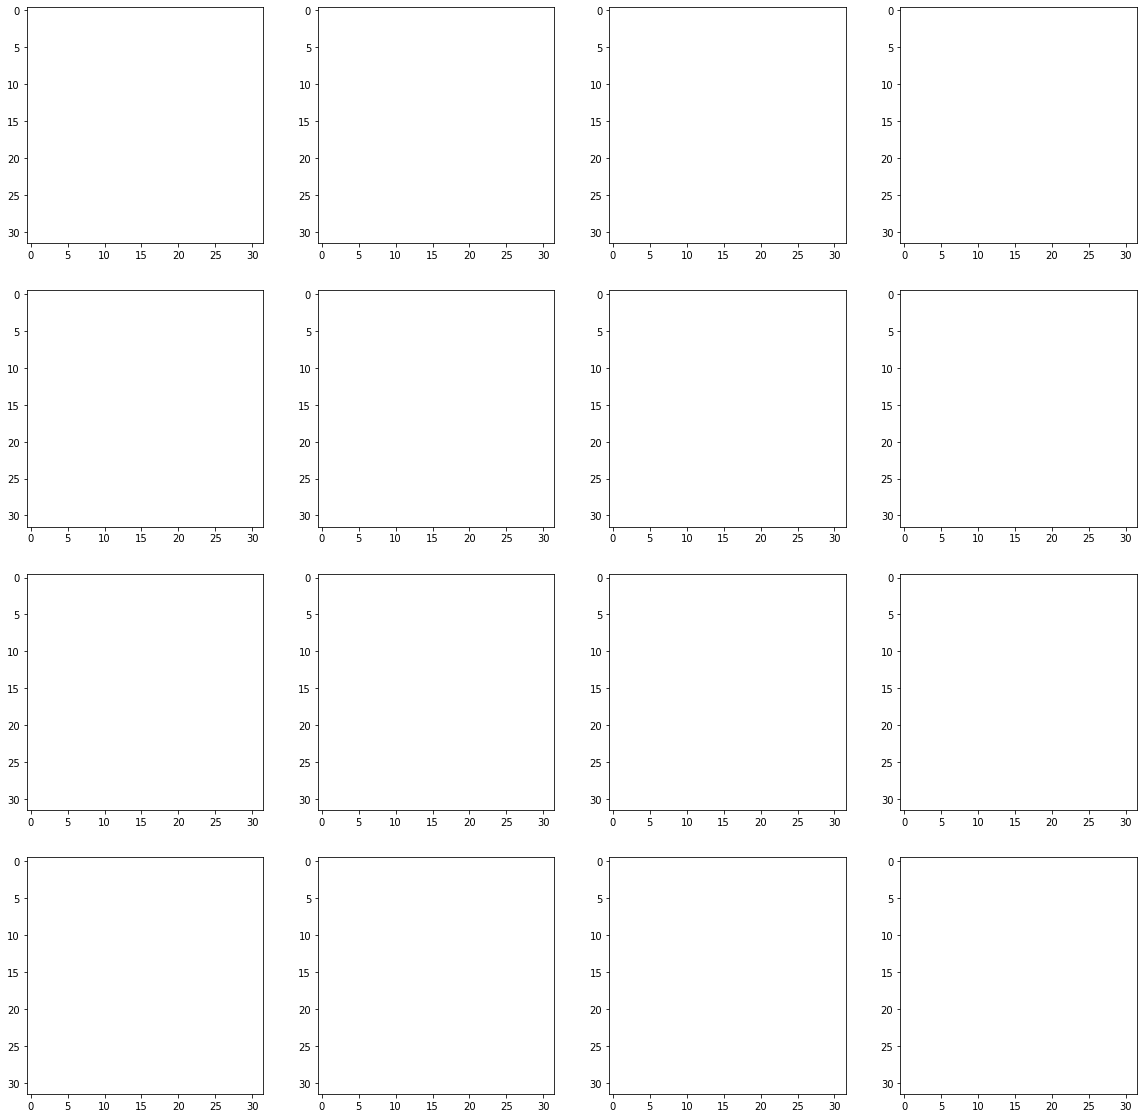

In [82]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(20,20))

for r in range(4):
  for c in range(4):
    axs[r][c].imshow(img[(r+1)*(c+1)-1])